In [8]:
import numpy as np
import json
import os

net_types = ["pfnn","spinn"]
net_type = net_types[1]
lmbd_start = 2.0
mu_start = 0.3
iteration = 100000
times = [40,10]
time = times[0]
nDIC = 36
noise = 0.1
noise_types = ["diff","exponential","threshold"]
noise_type = noise_types[0]
smoothing = ["min", "average", "none"][1]

def get_folder_list(run, results_folder="./results_inverse_noise/"):
    folder_list = []
    for folder_name in os.listdir(results_folder):
        if folder_name.startswith(run):
            folder_list.append(results_folder+folder_name)
    return folder_list


def read_data_file(filename):
    with open(filename, "r") as f:
        # Read the file and split each line
        steps = []
        values = []
        for line in f.readlines():
            step, value = line.strip().split(' ',1)
            steps.append(eval(step))
            values.append(eval(value))
    return steps, values

def moving_average(arr, window_size):
    window = np.ones(window_size)/window_size
    return np.apply_along_axis(lambda x: np.convolve(x, window, mode='valid'), 0, arr)

def moving_min(arr, window_size):
    new_arr = np.zeros((arr.shape[0] - window_size + 1, arr.shape[1]))
    for n_metric in range(arr.shape[1]):
        for i in range(new_arr.shape[0]):
            new_arr[i, n_metric] = np.min(arr[i:i+window_size, n_metric])
    return new_arr

def load_runs(folder_list, window_size=10):
    loss_history = []
    variables_history = []
    for folder in folder_list:
        loss_hist = np.loadtxt(folder + "/loss_history.dat")
        if smoothing == "min":
            loss_hist = moving_min(loss_hist, window_size)
        elif smoothing == "average":
            loss_hist = moving_average(loss_hist, window_size)
        loss_history.append(loss_hist)
        variables_history.append(read_data_file(folder + "/variables_history.dat"))

    steps_min = min(loss_hist.shape[0] for loss_hist in loss_history)
    loss_history = np.array([loss_hist[:steps_min] for loss_hist in loss_history])
    lambda_history = np.array([np.array(variables_hist[1])[:steps_min,0] for variables_hist in variables_history])
    mu_history = np.array([np.array(variables_hist[1])[:steps_min,1] for variables_hist in variables_history])

    return loss_history, lambda_history, mu_history

comparaison_types = net_types

folder_lists = []
for net_type, time in zip(comparaison_types, times):
    folder_name = f"{net_type}_lmbd-{lmbd_start}_mu-{mu_start}_nDIC-{nDIC}_noise-{noise_type}-{noise}_{time}min"
    folder_lists.append(get_folder_list(folder_name))
    # print(folder_name)
    print(f"{len(folder_lists[-1])} runs for {net_type} with {time} minutes")

with open(folder_lists[0][0] + "/config.json") as f:
    run_config = json.load(f)

loss_history, lambda_history, mu_history = [], [], []
for folder_list in folder_lists:
    loss_hist, lambda_hist, mu_hist = load_runs(folder_list)
    loss_history.append(loss_hist)
    lambda_history.append(lambda_hist)
    mu_history.append(mu_hist)



steps_loaded = [loss_hist[0,:, 0] for loss_hist in loss_history]
residuals = [loss_hist[:,:, -1] for loss_hist in loss_history]
PDE_loss = [np.mean(loss_hist[:,:, 1:3], axis=2) for loss_hist in loss_history]
Mat_loss = [np.mean(loss_hist[:,:, 3:5], axis=2) for loss_hist in loss_history] 
DIC_loss = [np.mean(loss_hist[:,:, 5:7], axis=2) for loss_hist in loss_history]


metrics = [residuals, PDE_loss, Mat_loss, DIC_loss]
metrics_names = ["Residuals", "PDE Loss", "Material Loss", "DIC Loss"]

10 runs for pfnn with 40 minutes
10 runs for spinn with 10 minutes


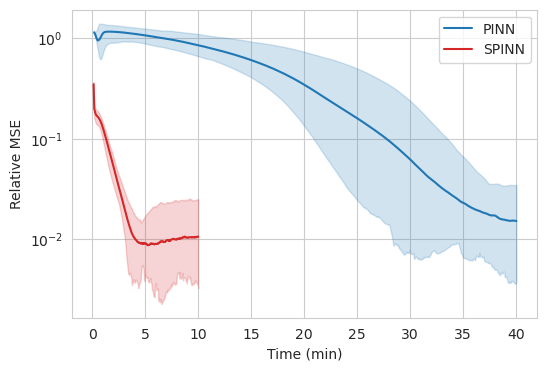

In [16]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
#seaborn whitegrid:
sns.set_style("whitegrid")

step_type = ["iteration", "time"][1]
time_unit = ["s", "min"][1]
metrics_idx = [0]#0: residuals, 1: PDE loss, 2: Material loss, 3: DIC loss
comp_idx = [0,1] #0: PINN, 1: SPINN
t_elapsed = run_config["elapsed"]
if step_type == "time":
    steps = [np.array(step_loaded) * time/step_loaded[-1] for step_loaded, time in zip(steps_loaded, times)]
    # if time_unit == "min":
    #     steps = [step/60 for step in steps]
else:
    steps = steps_loaded

palette = [sns.color_palette()[0], sns.color_palette()[3]]
def init_metrics(ax, metrics_idx=[0]):
    ax.set_yscale('log')
    lines = []
    scatters = []
    for comp_id in comp_idx:
        line = []
        scatter = []
        for idx in metrics_idx:
            ax.plot(steps[comp_id], metrics[idx][comp_id].mean(axis=0), alpha=1, color=palette[comp_id])
            # ax.fill_between(steps[noise_id], metrics[idx][noise_id].mean(axis=0) - metrics[idx][noise_id].std(axis=0), metrics[idx][noise_id].mean(axis=0) + metrics[idx][noise_id].std(axis=0), alpha=0.2, color=['b', 'r', 'g', 'y'][noise_id])
            ax.fill_between(steps[comp_id], metrics[idx][comp_id].min(axis=0), metrics[idx][comp_id].max(axis=0), alpha=0.2, color=palette[comp_id])
            line.append(ax.plot([], [], zorder=3, color=palette[comp_id], label=["PINN","SPINN"][comp_id]))#label=comparaison_types[comp_id])[0])
            scatter.append(ax.scatter([], [], c='k', zorder=4))
        lines.append(line)
        scatters.append(scatter)
    # for idx in metrics_idx:
    #     ax.plot(steps, metrics[idx].mean(axis=0), alpha=0.2, color=['b', 'r', 'g', 'y'][idx])
    #     # ax.fill_between(steps, metrics[idx].mean(axis=0) - metrics[idx].std(axis=0), metrics[idx].mean(axis=0) + metrics[idx].std(axis=0), alpha=0.2, color=['b', 'r', 'g', 'y'][idx])
    #     ax.fill_between(steps, metrics[idx].min(axis=0), metrics[idx].max(axis=0), alpha=0.2, color=['b', 'r', 'g', 'y'][idx])
    #     lines.append(ax.plot([], [], zorder=3, color=['b', 'r', 'g', 'y'][idx], label=metrics_names[idx])[0])
    #     scatters.append(ax.scatter([], [], c='k', zorder=4))

    ax.legend()
    ax.set_ylabel("Relative MSE")
    if step_type == "time":
        ax.set_xlabel(f"Time ({time_unit})")
    else:
        ax.set_xlabel("Iterations")
    return lines, scatters

def update_metrics(iterations, lines, scatters, metrics_idx=[0]):
    for line, scatter, noise_id in zip(lines, scatters, range(len(comparaison_types))):
        for idx in metrics_idx:
            line[idx].set_data(steps[noise_id], metrics[idx][noise_id][:iterations].mean(axis=0))
            scatter[idx].set_offsets(np.array([steps[noise_id][iterations], metrics[idx][noise_id][:iterations].mean(axis=0)]).T)

    return lines, scatters

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
lines, scatters = init_metrics(ax,  metrics_idx=metrics_idx)
# update_metrics(-1, lines, scatters, metrics_idx=metrics_idx)
plt.show()

# anim = animation.FuncAnimation(fig, update_losshistory, fargs=(line_pinn, line_spinn, scatter_pinn, scatter_spinn), frames=int(len(losshistory_pinn)/10), interval=100, repeat=False)
# HTML(anim.to_jshtml())

In [10]:
import seaborn as sns
sns.set_style("whitegrid")

plot_type = ['boxplot', 'violinplot'][1]

def plot_distribution(ax,df, parameter,metric,plot_type="violinplot",strip=True,label_info=True,save_fig=False,color="blue"):
    if plot_type == 'boxplot':
        sns.boxplot(x=parameter, y=metric, data=df, ax=ax)#, color="0.8")

    elif plot_type == 'violinplot':
        sns.violinplot(x=parameter, y=metric, data=df, ax=ax,inner="quartile", color=color)
  
    for patch in ax.collections:
        patch.set_alpha(0.7)  
        
    if strip:    
        sns.stripplot(x=parameter, y=metric, data=df,ax=ax, jitter=0.03, zorder=1, size=5, alpha=0.6, color="black")
    if label_info:
        # Calculate mean and number of points for each category
        mean_values = df.groupby(parameter)[metric].mean()
        std_values = df.groupby(parameter)[metric].std()
        count_values = df[parameter].value_counts()

        # Add labels for each category
        column_values = sorted(df[parameter].unique(),key=str.casefold if isinstance(df[parameter].iloc[0],str) else lambda x: x)
        
        for i, value in enumerate(column_values):
            mean = mean_values[value]
            std = std_values[value]
            count = count_values[value]
            label = f"Mean: {mean:.2e}\nStd: {std:.2e}\nCount: {count}"
            ax.text(i, ax.get_ylim()[1], label, ha='center', va='top',
                bbox=dict(boxstyle='square,pad=0.5', fc='1', ec='0.5'),
                transform=ax.transData)
                        
            
    if save_fig:
        plt.savefig(f"results/figures/{parameter}_influence.png",dpi=300)

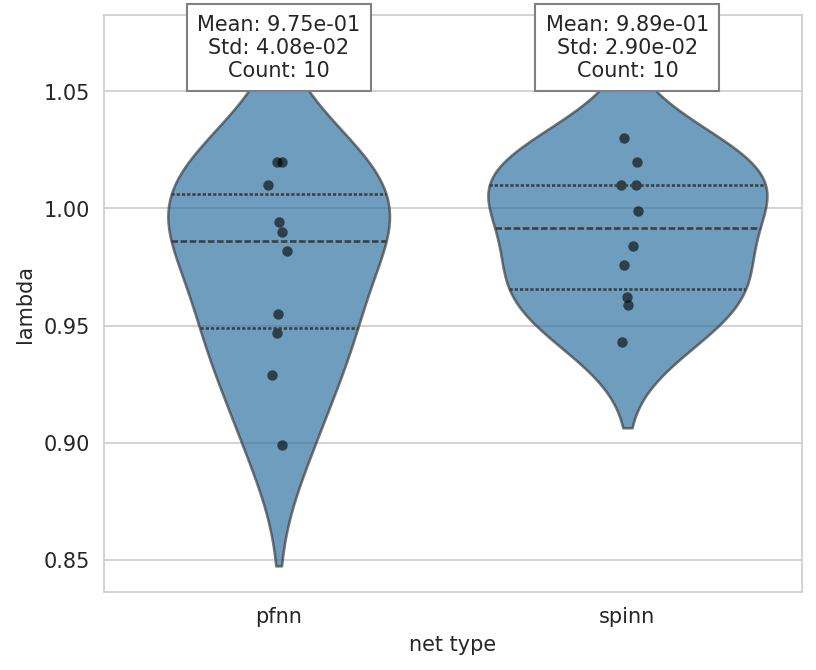

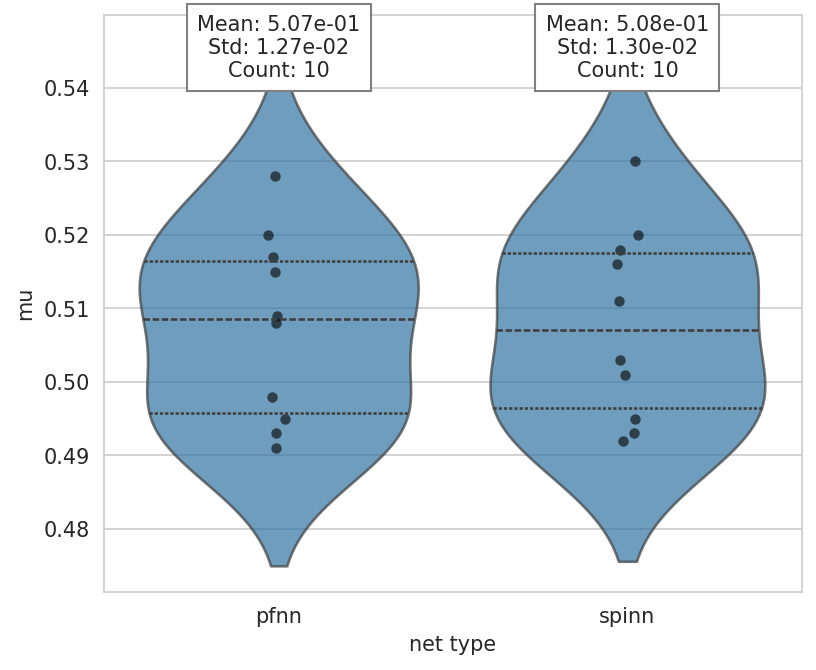

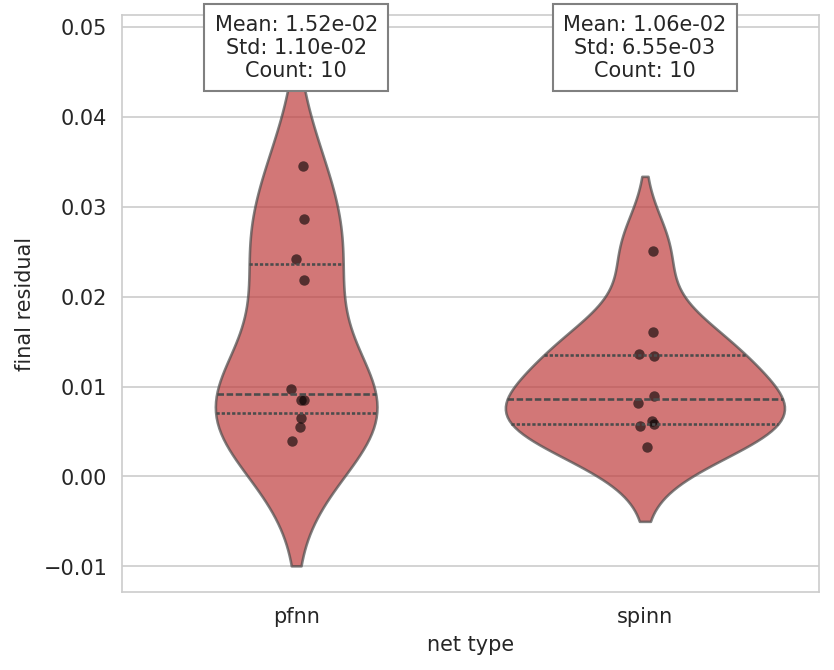

In [11]:
import pandas as pd

final_res = [residuals[comp_id][:, -1] for comp_id in range(len(comparaison_types))]
final_lambda = [lambda_history[comp_id][:, -1] for comp_id in range(len(comparaison_types))]
final_mu = [mu_history[comp_id][:, -1] for comp_id in range(len(comparaison_types))]

df_final = []
comp_idx = [0,1] #0: PINN, 1: SPINN

for comp_id in comp_idx:
    for i in range(len(final_res[comp_id])):
        df_final.append({"final residual": final_res[comp_id][i], "lambda": final_lambda[comp_id][i], "mu": final_mu[comp_id][i], "net type": comparaison_types[comp_id]})

df_final = pd.DataFrame(df_final)


palette = sns.color_palette()
fig, ax = plt.subplots(1, 1, figsize=(3*len(comp_idx), 5), dpi=150)
plot_distribution(ax,df_final, "net type", "lambda", color=palette[0])

fig, ax = plt.subplots(1, 1, figsize=(3*len(comp_idx), 5), dpi=150)
plot_distribution(ax,df_final, "net type", "mu", color=palette[0])

fig, ax = plt.subplots(1, 1, figsize=(3*len(comp_idx), 5), dpi=150)
plot_distribution(ax,df_final, "net type", "final residual", color=palette[3])

# df_final.head()


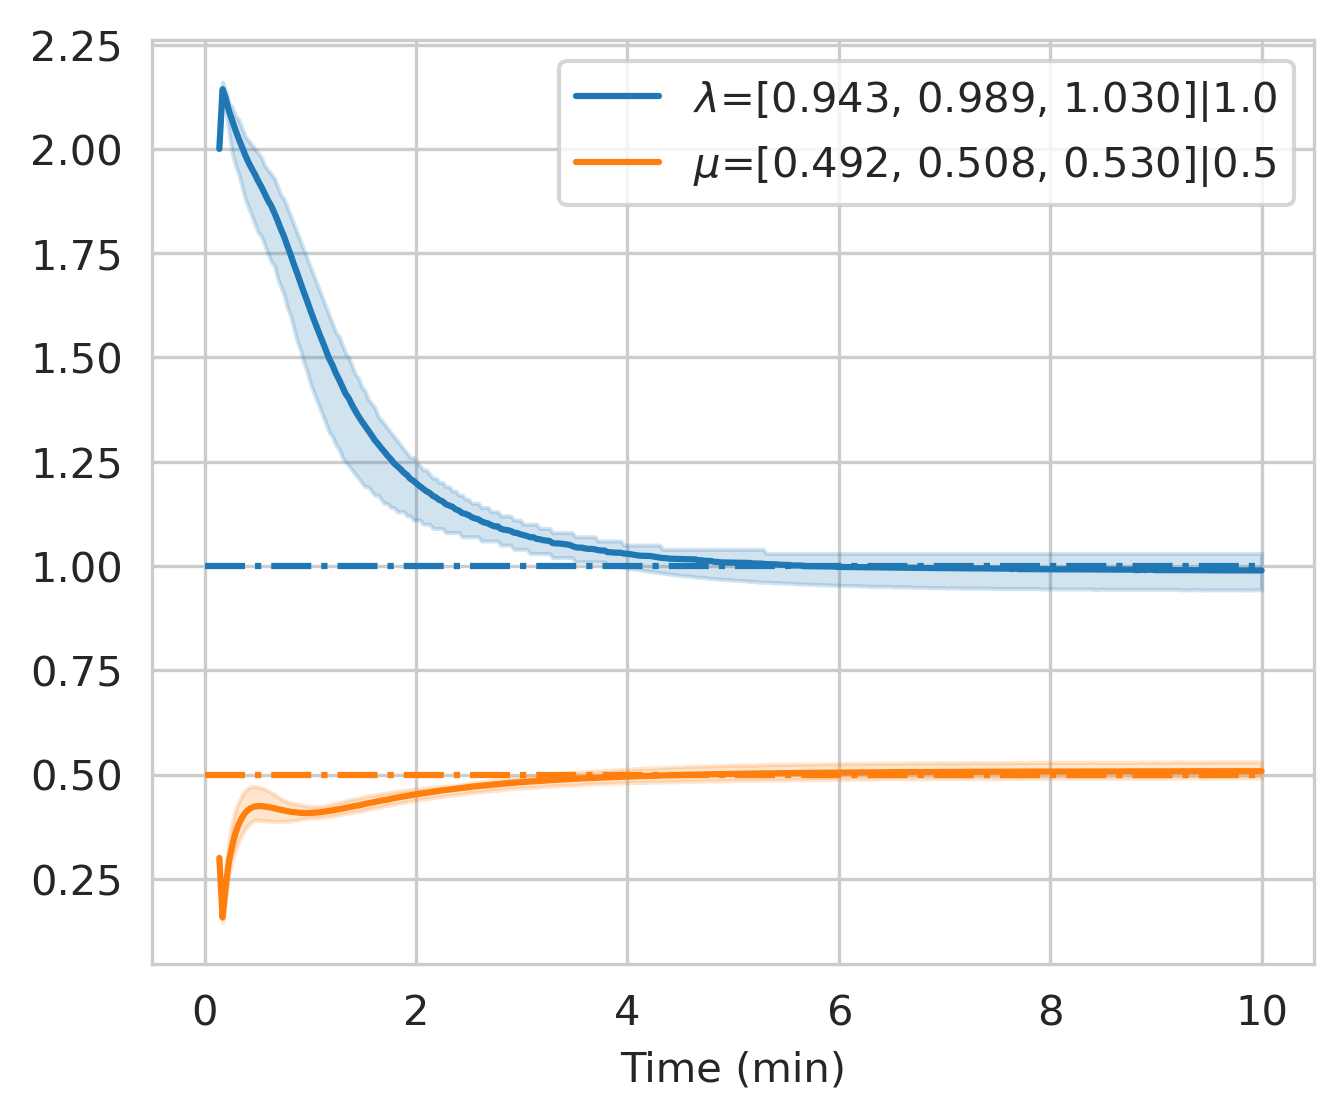

In [18]:
lambda_actual = run_config["lmbd_actual"]
mu_actual = run_config["mu_actual"]
comp_idx = [1] #0: PINN, 1: SPINN
palette = sns.color_palette()

def init_variables(ax):

    for comp_id in comp_idx: 
        ax.hlines(y=lambda_actual,xmin=0, xmax=steps[comp_id].max(), linestyles='-.', colors=palette[0])#, label=r"Actual $\lambda=$"+f"{lambda_actual}")
        ax.hlines(y=mu_actual,xmin=0, xmax=steps[comp_id].max(), linestyles='-.', colors=palette[1])#, label=r"Actual $\mu=$"+f"{mu_actual}")
        ax.plot(steps[comp_id], lambda_history[comp_id].mean(axis=0), color=palette[0], alpha=1, label=r"$\lambda$"+f"=[{lambda_history[comp_id].min(axis=0)[-1]:.3f}, {lambda_history[comp_id].mean(axis=0)[-1]:.3f}, {lambda_history[comp_id].max(axis=0)[-1]:.3f}]|{lambda_actual}")
        ax.plot(steps[comp_id], mu_history[comp_id].mean(axis=0), color=palette[1], alpha=1, label=r"$\mu$"+f"=[{mu_history[comp_id].min(axis=0)[-1]:.3f}, {mu_history[comp_id].mean(axis=0)[-1]:.3f}, {mu_history[comp_id].max(axis=0)[-1]:.3f}]|{mu_actual}")
        ax.fill_between(steps[comp_id], lambda_history[comp_id].min(axis=0), lambda_history[comp_id].max(axis=0), alpha=0.2, color=palette[0])
        ax.fill_between(steps[comp_id], mu_history[comp_id].min(axis=0), mu_history[comp_id].max(axis=0), alpha=0.2, color=palette[1])

    ax.legend()
    if step_type == "time":
        ax.set_xlabel(f"Time ({time_unit})")
    else:
        ax.set_xlabel("Iterations")
    
    return ax

def update_variables(iterations, line_lambda, line_mu, scatter_mu, scatter_lambda,ax):

    line_lambda.set_data(steps[:iterations], lambda_history.mean(axis=0)[:iterations])
    line_lambda.set_label(r"$\lambda$"+f"={lambda_history.mean(axis=0)[iterations]:.3f}|{lambda_actual}")
    scatter_lambda.set_offsets([steps[iterations], lambda_history.mean(axis=0)[iterations]])
    line_mu.set_data(steps[:iterations], mu_history.mean(axis=0)[:iterations])
    line_mu.set_label(r"$\mu$"+f"={mu_history.mean(axis=0)[iterations]:.3f}|{mu_actual}")
    scatter_mu.set_offsets([steps[iterations], mu_history.mean(axis=0)[iterations]])
    ax.legend()
    return line_lambda, line_mu, scatter_mu, scatter_lambda, ax

fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=300)
ax = init_variables(ax)
# update_variables(-1, line_lambda, line_mu, scatter_mu, scatter_lambda, ax)
plt.show()

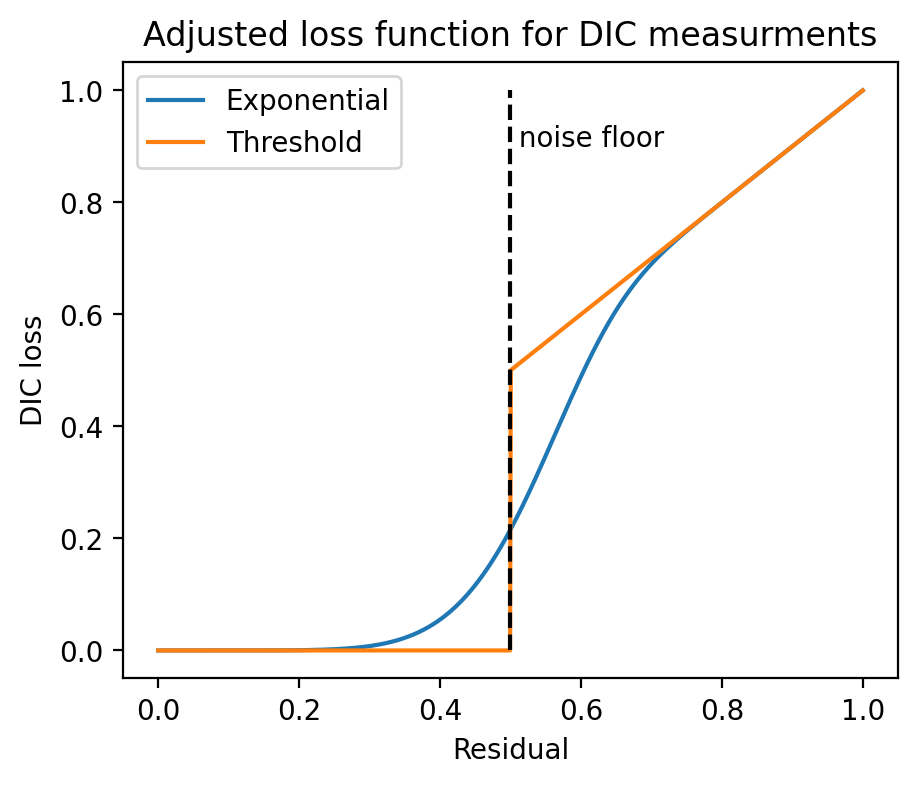

In [86]:
#exponential decay
max_range = 1
noise_floor = max_range/2
dist = np.linspace(0, max_range, 1000)

def exponential_loss(dist, noise_floor):
    return dist*(1-np.exp(-(dist/(1.1*noise_floor))**6))
def threshold_loss(dist, noise_floor):
    return np.where(np.abs(dist)<noise_floor, 0, dist)
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)
plt.plot(dist, exponential_loss(dist, noise_floor), label="Exponential")
plt.plot(dist, threshold_loss(dist, noise_floor), label="Threshold")
# plt.plot(dist, dist, 'k--')
plt.vlines(noise_floor, 0, max_range, linestyles='--',colors='k')
plt.text(noise_floor, max_range*0.9, f" noise floor", color='k')
plt.title("Adjusted loss function for DIC measurments")
plt.xlabel("Residual")
plt.ylabel("DIC loss")
plt.legend()
